# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import pickle
import ast

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_auc_score
from hyperopt import hp
import lightgbm as lgb
from skopt import BayesSearchCV

sys.path += ['./ilikeds']
import eda 
import helper_functions as h
import train_classifier as t

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
# azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
# customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

azdias = pd.read_pickle ('../data/azdias.p')    
customers = pd.read_pickle ('../data/customers.p')    

In [3]:
# read in feature info file
feat_info = pd.read_csv('./feats_info.csv', sep=';', names=['feat', 'type', 'unknown'])
feat_info.set_index('feat', inplace =True)

In [4]:
# create  a EDA  instance for Azdias.
eda_azdias= eda.EDA(azdias, feat_info, label = 'Azdias')

# create  a EDA  instance for Azdias. for  customers
eda_customers= eda.EDA(customers, feat_info, label = 'Customers')

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Data Cleaning

#### Step 1: Removing undefined features

In [5]:
feats_todrop = []
feats_wo_def = list(set(eda_azdias.data.columns) - set(eda_azdias.feat_info.index))

eda_azdias.data.drop(columns = feats_wo_def, inplace =True)
eda_customers.data.drop(columns = feats_wo_def, inplace =True)

# Removing the three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP') in Customers
feats_customers_excl  = list(set(eda_customers.data.columns) - set(eda_azdias.data.columns))
feats_customers_excl
eda_customers.data.drop(columns = feats_customers_excl, inplace =True)

####  Step 2:  Converting of missing and unknown data to NaN

In [7]:
eda_azdias.missing2nan()
eda_customers.missing2nan()

Number of missing values in Azdias:
Before converstion is 28909421
Ater converstion IS 80037210
Increase in missing values: 176.86 % 
Number of missing values in Customers:
Before converstion is 12553501
Ater converstion IS 22936825
Increase in missing values: 82.71 % 


####  Step 3:  Delete rows with more NaN values

(array([3.4000e+01, 1.9300e+02, 7.5700e+02, 2.9700e+03, 4.6420e+03,
        7.6070e+03, 1.6657e+04, 1.9227e+04, 2.6354e+04, 3.2940e+04,
        5.3739e+04, 4.4841e+04, 4.6389e+04, 6.2816e+04, 4.6531e+04,
        4.7817e+04, 4.9163e+04, 7.0863e+04, 8.7205e+04, 8.4759e+04,
        1.7085e+04, 1.3091e+04, 1.4340e+03, 2.9700e+02, 4.8900e+02,
        6.0200e+02, 9.4500e+02, 1.9340e+03, 2.1110e+03, 2.6730e+03,
        3.1240e+03, 4.4200e+03, 3.1900e+03, 3.3450e+03, 4.3140e+03,
        4.4640e+03, 5.1010e+03, 4.3640e+03, 3.5730e+03, 1.7320e+03,
        7.1300e+02, 7.0400e+02, 1.5100e+02, 8.7000e+01, 7.3000e+01,
        1.1800e+02, 1.0300e+02, 1.2000e+02, 2.7400e+02, 2.2200e+02,
        2.3200e+02, 4.1000e+02, 3.2900e+02, 4.2400e+02, 5.0600e+02,
        1.0410e+03, 1.3350e+03, 3.3500e+02, 2.0000e+02, 6.5000e+01,
        1.7000e+01, 2.3000e+01, 5.7000e+01, 8.0000e+01, 1.5500e+02,
        3.0000e+02, 3.2500e+02, 4.6800e+02, 5.5500e+02, 7.7400e+02,
        7.0500e+02, 7.1800e+02, 1.1940e+03, 1.10

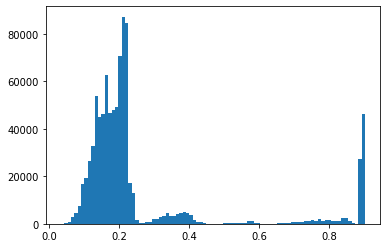

In [8]:
rows_n_nans = azdias.isnull().sum(axis=1)
plt.hist(rows_n_nans / azdias.shape[1], bins=90)

In [9]:
_, rows_droped = h.split_dataset(azdias, threshold=0.25)
n_deleted_rows = rows_droped.shape[0]
print(f'Before delete the missing rows, {eda_azdias} has {eda_azdias.data.shape[0]} rows')
azdias.drop(index = rows_droped.index, inplace =True)
print(f'After delete the missing rows, {eda_azdias} has {eda_azdias.data.shape[0]} rows')
print(f'Delete {n_deleted_rows} rows in total')

Before delete the missing rows, Azdias has 891221 rows
After delete the missing rows, Azdias has 736684 rows
Delete 154537 rows in total


In [10]:
_, rows_droped = h.split_dataset(customers, threshold=0.25)
n_deleted_rows = rows_droped.shape[0]
print(f'Before delete the high missing rate rows, {eda_customers} has {eda_customers.data.shape[0]} rows')
eda_customers.data.drop(index = rows_droped.index, inplace =True)
print(f'After delete the hitg missing rate rows, {eda_customers} has {eda_customers.data.shape[0]} rows')
print(f'Delete {n_deleted_rows} rows in total')

Before delete the missing rows, Customers has 191652 rows
After delete the missing rows, Customers has 134251 rows
Delete 57401 rows in total


####  Step 4: Delete columns/features with more NaN values

Text(0.5, 1.0, 'Distribution of missing value per column')

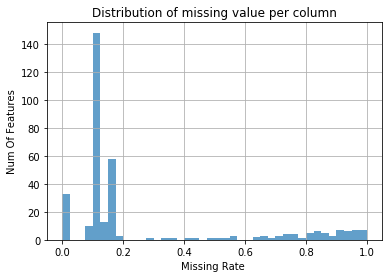

In [11]:
eda_azdias.feat_info.percent_of_nans.sort_values().hist(bins = 40, alpha = 0.7)
plt.xlabel('Missing Rate ')
plt.ylabel('Num Of Features')
plt.title('Distribution of missing value per column')

In [12]:
thr_col_missing = 0.37
feats_todrop_azdias = eda_azdias.feat_info.loc[eda_azdias.feat_info.percent_of_nans > thr_col_missing].index
feats_todrop_azdias

Index(['AGER_TYP', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24',
       'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS',
       'D19_BANKEN_LOKAL', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST',
       'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV',
       'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN',
       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_HANDWERK', 'D19_HAUS_DEKO',
       'D19_KINDERARTIKEL', 'D19_KOSMETIK', 'D19_LEBENSMITTEL', 'D19_LOTTO',
       'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER', 'D19_REISEN',
       'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE', 'D19_SOZIALES',
       'D19_TECHNIK', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24',
       'D19_TELKO_DATUM', 'D19_TELKO_MOBILE', 'D19_TELKO_O

In [13]:
feats_todrop_customers = eda_customers.feat_info.loc[eda_customers.feat_info.percent_of_nans >thr_col_missing ].index
feats_todrop_customers

Index(['AGER_TYP', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ANZ_12',
       'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT',
       'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST',
       'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV',
       'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN',
       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_OFFLINE_DATUM',
       'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_HANDWERK',
       'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KOSMETIK',
       'D19_LEBENSMITTEL', 'D19_LOTTO', 'D19_NAHRUNGSERGAENZUNG',
       'D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE',
       'D19_SONSTIGE', 'D19_TECHNIK', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24',
       'D19_TELKO_DATUM', 'D19_TELKO_MOBILE', 'D19_TELKO_OFFLINE_DATUM',
    

In [14]:
# Get features with high missing rates in both datasets
feats_todrop_comm = set(feats_todrop_customers).intersection(set(feats_todrop_azdias))
feats_todrop_comm = list(feats_todrop_comm)
feats_todrop_comm

['D19_GARTEN',
 'D19_BANKEN_REST',
 'D19_VERSI_OFFLINE_DATUM',
 'D19_BILDUNG',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_TELKO_OFFLINE_DATUM',
 'D19_VERSAND_DATUM',
 'D19_SCHUHE',
 'D19_GESAMT_ONLINE_DATUM',
 'VHA',
 'D19_TECHNIK',
 'D19_VOLLSORTIMENT',
 'D19_VERSAND_ONLINE_DATUM',
 'D19_TELKO_MOBILE',
 'D19_BANKEN_DATUM',
 'D19_HANDWERK',
 'D19_VERSICHERUNGEN',
 'D19_HAUS_DEKO',
 'TITEL_KZ',
 'EXTSEL992',
 'D19_BANKEN_LOKAL',
 'D19_TELKO_DATUM',
 'D19_TIERARTIKEL',
 'D19_BANKEN_GROSS',
 'D19_BEKLEIDUNG_REST',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_LOTTO',
 'D19_SONSTIGE',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_VERSI_ANZ_12',
 'D19_DROGERIEARTIKEL',
 'D19_VERSI_ANZ_24',
 'D19_TELKO_REST',
 'D19_VERSAND_OFFLINE_DATUM',
 'D19_GESAMT_ANZ_12',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'D19_VERSI_DATUM',
 'D19_SAMMELARTIKEL',
 'D19_DIGIT_SERV',
 'D19_VERSI_ONLINE_DATUM',
 'D19_TELKO_ANZ_12',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_BANKEN_DIREKT',
 'D19_BANKEN_ANZ_24',
 'D19_NAHRUNGSERGAENZUNG',
 'D19_VERSAND_ANZ_12'

In [15]:
print(f'Before delete the high missing rate features/columns, {eda_azdias} has {eda_azdias.data.shape[1]} features.')
azdias.drop(columns=feats_todrop_comm, inplace=True)
print(f'After delete the high missing rate features/columns, {eda_azdias} has {eda_azdias.data.shape[1]} features.')

print()

print(f'Before delete the high missing rate features/columns, {eda_customers} has {eda_customers.data.shape[1]} features.')
customers.drop(columns=feats_todrop_comm, inplace=True)
print(f'After delete the high missing rate features/columns, {eda_customers} has {eda_customers.data.shape[1]} features.')

print()
print('Delete {len(feats_todrop_comm)} features in total')

Before delete the high missing rate features/columns, Azdias has 340 features.
After delete the high missing rate features/columns, Azdias has 270 features.
Before delete the high missing rate features/columns, Customers has 340 features.
After delete the high missing rate features/columns, Customers has 270 features.
Delete {len(feats_todrop_comm)} features in total


####  Step  5:  Delete duplicate features

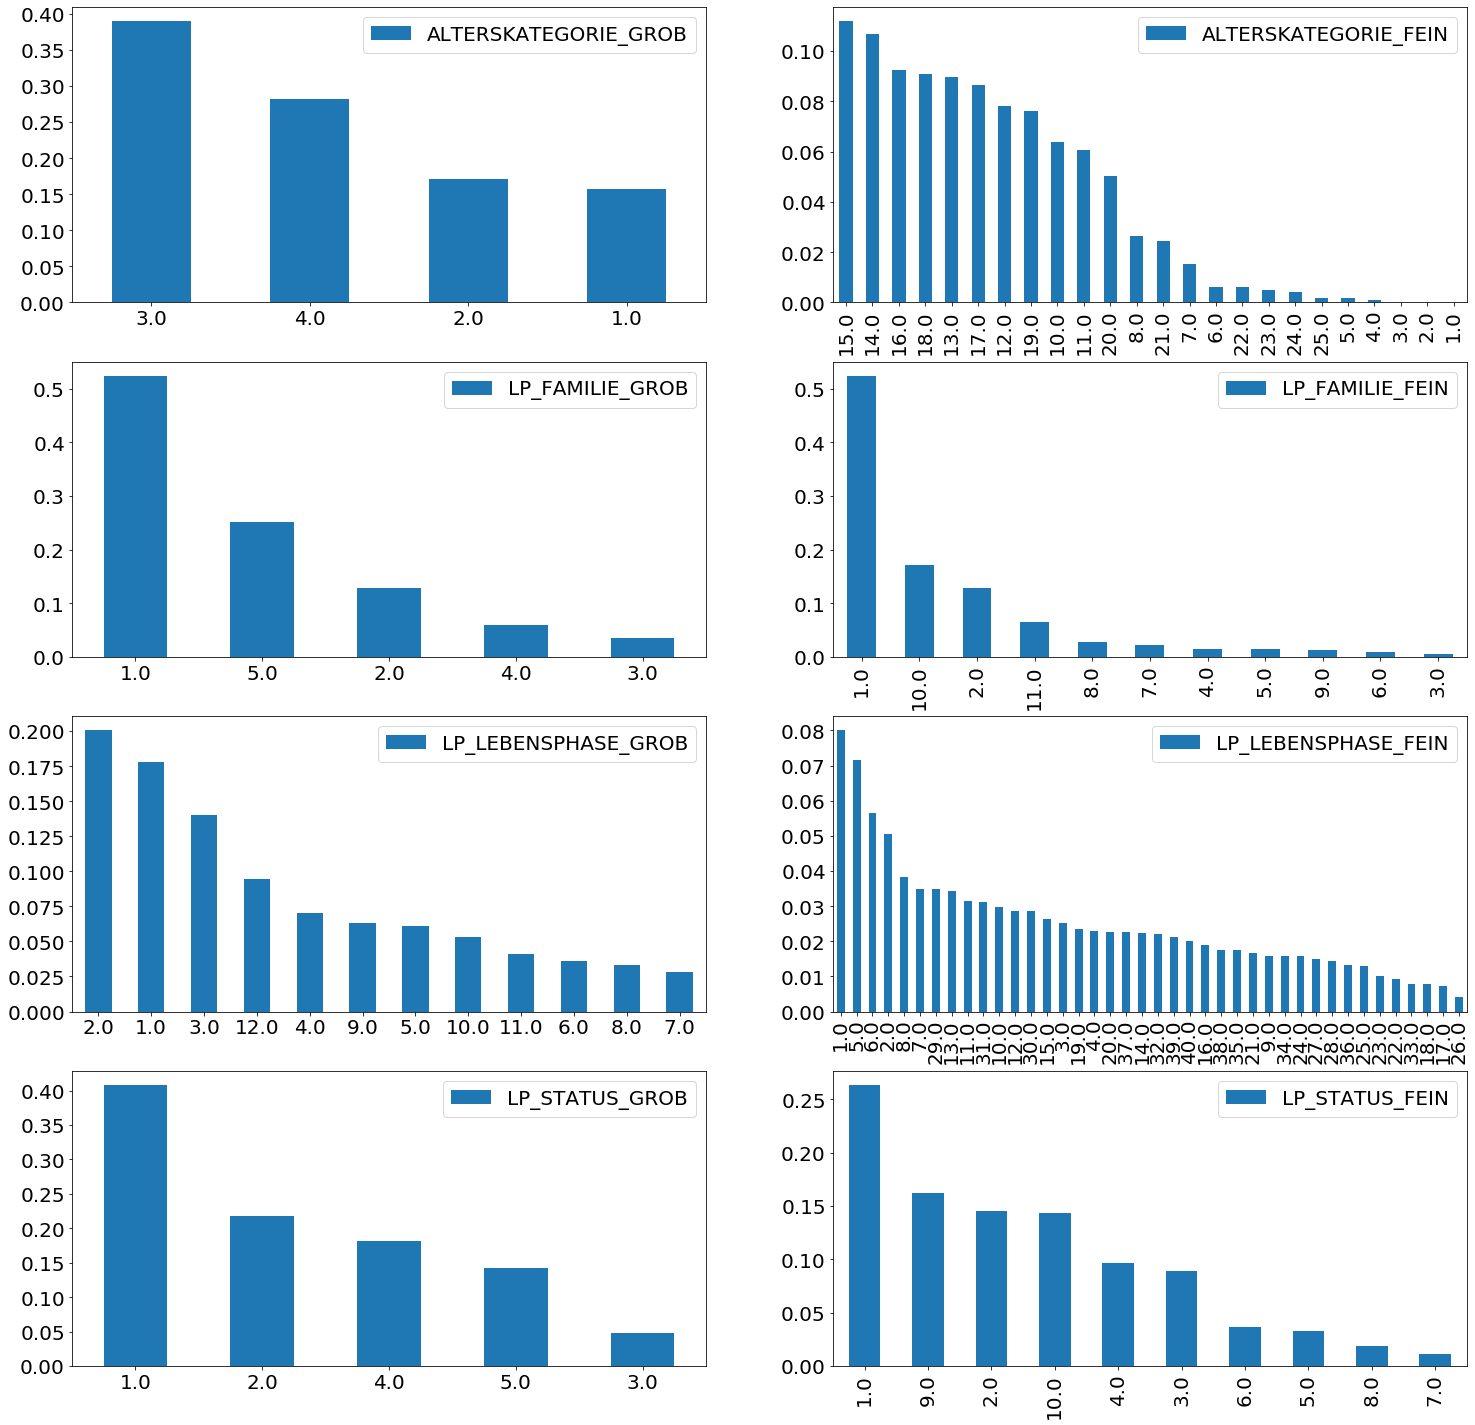

In [16]:
feats_fein =[x for x in eda_azdias.data.columns if x.endswith( '_FEIN')]
feats_grob = [x for x in eda_azdias.data.columns if x.endswith( '_GROB')]
feats_duplicate = [x for x in zip(pd.Series(feats_grob).sort_values(), pd.Series(feats_fein).sort_values())]
h.plot_2feats_comparison(eda_azdias.data, feats_duplicate)   

Both features on the same line have the same meaning. Features with a suffix of _GROB on the left represent coarse-grained information, and _FEIN represents fine-grained features. I decided to delete these duplicate features, 'ALTERSKATEGORIE_FEIN', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN', 'LP_STATUS_GROB', 'CAMEO_DEU_2015'. Because some of them are undefined, or  use the corresponding _GROB feature is enough.

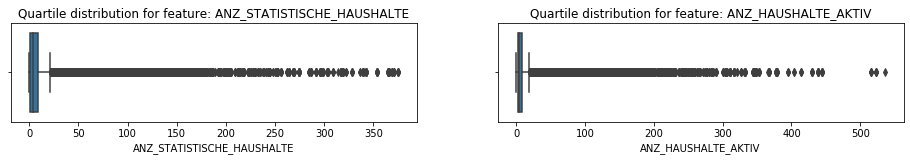

In [17]:
#  ANZ_STATISTISCHE_HAUSHALTE, ANZ_HAUSHALTE_AKTIV :  number of households in the building
#  Delete ANZ_STATISTISCHE_HAUSHALTE, because they are duplicated.

feats_HAUSHALTE = ['ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_HAUSHALTE_AKTIV']
h.plot_boxplot(eda_azdias.data, feats_HAUSHALTE, n_cols =2,  figsize = (16, 4))     

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')